<a href="https://colab.research.google.com/github/davidfrostcruz/advance_analytics/blob/main/assignment_tabular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment 1: predictive modeling on tabular data**

---


The project aims to: construct a machine learning method to predict the "price per night" of Airbnb properties in Belgium. Each section from the project contains the code and their explanation. 

# Importing Packages


In [125]:
# Import libraries
!pip install pandas-profiling
!pip install ydata-profiling
!pip install geopy
!pip install autoviz
!pip install matplotlib
!pip install -U textblob
!pip install statsmodels
!pip install missingno
!python -m textblob.download_corpora
!pip install missingpy
!pip install scikit-learn
!pip install sklearn
import pickle
import re
import numpy as np 
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import os
import sklearn
import joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is alread

# Accessing Data Files

In [126]:
# # Import files using Google colab
# from google.colab import files
# upload = files.upload()
# df = pd.read_csv('train.csv')
# df.head

In [127]:
# Accessing drive files 
# Setting package for drive
!pip install pyDrive
from google.colab import files
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')
# Setting up directory
directory_path = "/content/drive/MyDrive/analytics/data_1"
os.chdir("/content/drive/MyDrive/analytics/data_1")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
# Set path to the directory containing the training dataset
path_copy = "/content/drive/MyDrive/analytics/data_1/train.csv"
df_or = pd.read_csv(path_copy) # Getting the original training data Set
df = df_or.copy() # Keeping an exact copy from the data set

#### Defining functions to use

In this section, the used functions are defined. Make sure to run it before the rest of the code. 

EDA

In [129]:
# Defining numerical and categorical features of the data set 
numerical_features = [
'property_max_guests', 'host_response_rate', 'booking_max_nights', 
'booking_min_nights', 'booking_availability_30', 
'booking_availability_60', 'booking_availability_90',
'booking_availability_365', 'reviews_num', 'reviews_rating', 'reviews_acc', 'reviews_cleanliness',
'reviews_checkin', 'reviews_communication', 'reviews_location',
'reviews_value', 'reviews_per_month', 'target'
]
categorical_features = [
'property_summary', 'property_space',
'property_desc', 'property_neighborhood', 'property_notes',
'property_zipcode', 'property_lat', 'property_lon',
'property_type', 'property_room_type',
'property_bathrooms', 'property_bedrooms', 'property_beds',
'property_bed_type', 'property_amenities', 'property_sqfeet',
'property_last_updated', 'host_id',
'host_location', 'host_about', 'host_response_time',
'host_nr_listings', 'host_nr_listings_total',
'host_verified', 'booking_price_covers', 'booking_cancel_policy',
'extra', 'property_id', 'property_name', 'property_transit', 
'property_access', 'property_interaction', 'property_rules', 
'property_scraped_at', 'host_since', 'reviews_first', 'reviews_last'
]

text_columns = [
    'property_name', 'property_summary', 'property_space',
                'property_desc', 'property_neighborhood', 'property_notes',
                'property_transit', 'property_access', 'property_interaction',
                'property_rules'
] # The text columns will be treated separately for featuring later on

In [130]:
# Function for obtaining the descriptive statistics about the target feature
def stats_target(df, target):
  target_stats = df[target].describe() # Getting the target's descriptive statistics
  stats_target_df = pd.DataFrame(target_stats) # Getting a dataframe
  return stats_target_df

In [131]:
# Function for obtaining the best distribution of target variable
from scipy import stats

def find_best_distribution(data, feature):
    # Fit different distributions to the data
    distributions = [
        stats.norm,  # Normal distribution
        stats.expon,  # Exponential distribution
        stats.gamma,  # Gamma distribution
        stats.lognorm,  # Lognormal distribution
        stats.beta,  # Beta distribution
        stats.uniform  # Uniform distribution
    ]

    # Compute the AIC for each distribution
    aic_values = []
    for distribution in distributions:
        params = distribution.fit(data[feature])
        log_likelihood = distribution.logpdf(data[feature], *params).sum()
        aic = -2 * log_likelihood + 2 * len(params)
        aic_values.append(aic)

    # Select the distribution with the lowest AIC
    best_distribution = distributions[np.argmin(aic_values)]

    # Return the name of the best fitting distribution
    return best_distribution.name

In [132]:
import seaborn as sns

def univariate_plotting(df, feature):
    # Plot histogram with KDE
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=feature, kde=True, bins=30)
    plt.xlabel('Measurement')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()

    # Plot box plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=feature, notch=True, sym='o')
    plt.xlabel('Group')
    plt.ylabel('Measurement')
    plt.title('Box Plot')
    plt.show()

    # Plot kernel density estimate
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=df, x=feature)
    plt.xlabel('Measurement')
    plt.ylabel('Density')
    plt.title('Kernel Density Plot')
    plt.show()

In [133]:
# def plot_distribution(df, numerical_features, categorical_features):
#     # Plot numerical features
#     for feature in numerical_features:
#         # Create a figure with subplots
#         fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#         # Plot histogram with KDE
#         sns.histplot(data=df, x=feature, kde=True, ax=axs[0])
#         axs[0].set_xlabel('Measurement')
#         axs[0].set_ylabel('Frequency')
#         axs[0].set_title('Histogram with KDE')

#         # Plot box plot
#         axs[1].boxplot(df[feature], notch=True, sym='o')
#         axs[1].set_xlabel('Group')
#         axs[1].set_ylabel('Measurement')
#         axs[1].set_title('Box Plot')

#         # Plot kernel density estimate
#         sns.kdeplot(data=df, x=feature, ax=axs[2])
#         axs[2].set_xlabel('Measurement')
#         axs[2].set_ylabel('Density')
#         axs[2].set_title('Kernel Density Plot')

#         # Adjust the layout
#         plt.tight_layout()

#         # Show the plot
#         plt.show()

#     # Plot categorical features
#     for feature in categorical_features:
#         # Create a count plot
#         sns.countplot(data=df, x=feature)
#         plt.xlabel('Categories')
#         plt.ylabel('Count')
#         plt.title('Count Plot')
#         plt.xticks(rotation=90)
#         plt.tight_layout()

#         # Show the plot
#         plt.show()

# # Usage example
# plot_distribution(df, numerical_features, categorical_features)

In [134]:
# Definying a function for correlation identification with heatmap visualization
def correlation_heatmap(df):
    # Getting correlation matrix
    corr_matrix = df.corr()
    # Print correlation matrix
    print("Correlation Matrix:\n", corr_matrix.to_string())
    # Create heatmap plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmin=-1, vmax=1, fmt='.1f')
    # Show the plot
    plt.show()

In [135]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Defining a function for doing clustering on two categorical features
def plot_dendrogram(dataframe):
    # Compute the linkage matrix using Ward's method
    linkage_matrix = linkage(dataframe, method='ward')

    # Plot the dendrogram
    fig, ax = plt.subplots(figsize=(10, 5))
    dendrogram(linkage_matrix)
    plt.xlabel('Locations')
    plt.ylabel('Distance')
    plt.show()

In [136]:
# Getting the accurate types for the features within the data set 
def convert_correct_types(df):
    if df['property_bedrooms'].dtype == 'float64':
        df['property_bedrooms'] = df['property_bedrooms'].fillna(np.NaN).astype('Int64')
    if df['property_beds'].dtype == 'float64':
        df['property_beds'] = df['property_beds'].fillna(np.NaN).astype('Int64')
    if df['booking_price_covers'].dtype == 'float64':
        df['booking_price_covers'] = df['booking_price_covers'].fillna(np.NaN).astype('Int64')
    if df['host_response_rate'].dtype == 'float64':
        df['host_response_rate'] = df['host_response_rate'].fillna(np.NaN).astype('Int64')
    return df 

In [137]:
# Making content of zipcode homogeneous 
def convert_zipcode(df):
    if df['property_zipcode'].dtype == 'object':
        df['property_zipcode'] = df['property_zipcode'].str.strip()
        df['property_zipcode'] = df['property_zipcode'].str.replace(' ', '')
    return df

In [138]:
# Defining function for identifying identical features
def duplicate_features(data):
    duplicates = set()  
    kept_features = []
    removed_features = []  

    for i, column1 in enumerate(data.columns):  
        for j, column2 in enumerate(data.columns[i + 1:], i + 1):
            # Checking if column1 and column2 are equal
            if data[column1].equals(data[column2]):
                # If they are equal, add column2 to the duplicates set
                duplicates.add(column2)
                # Get the kept feature 
                kept_feature = data.columns[i]
                kept_features.append(kept_feature)  # List of the kept features
                removed_features.append(column2)

                # Print the duplicated feature
                print(f"Feature '{column2}' is duplicated.")

Missigness

In [139]:
# Defining function for recognizing missing values within features
def features_missing_values(df):
    missing = df.isnull().sum() # Identifying missing sum within each feature
    missing_pct = (missing / len(df)) * 100 # Percentage of missingness compare to total n in dataset
    missing_values = pd.concat([
        missing, missing_pct.astype('int64')], # Getting type int64 for Percentage column 
        axis=1, 
        keys=[
            'Total Missing', 'Percentage (%)']
     ) # Creating dataframe with % of missing for each feature
    missing_values.sort_values(by='Total Missing', ascending=False, inplace=True)
    missing_values.index.name = 'Feature'
    return missing_values 

In [140]:
# Defining function for identifying the features with missing rates greater than 90%
def identify_missing_features(data, threshold=0.9):
    missing_perc = data.isnull().sum() / len(data) * 100  # Calculate the percentage of missingness within each feature
    high_missing_features = missing_perc[missing_perc >= threshold * 100].index.tolist()  # Features with missing rate >= 90%

    if not high_missing_features:
        print("No features with missingness rate greater than {}% found. The default threshold is 90%.".format(threshold * 100))
    else:
        print("The following features have a missing rate greater than {}%:".format(threshold * 100))
        for feature in high_missing_features:
            print("- {}".format(feature))

In [141]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

def impute_missing_values(df):
    imputed_df = df.copy()

    numerical_features_remaining = [col for col in numerical_features if col in imputed_df.columns]
    categorical_features_remaining = [col for col in categorical_features if col in imputed_df.columns]

    knn_imputer = KNNImputer(n_neighbors=5)

    imputed_numerical = knn_imputer.fit_transform(imputed_df[numerical_features_remaining])
    imputed_numerical_df = pd.DataFrame(imputed_numerical, columns=numerical_features_remaining)
    imputed_numerical_df[numerical_features_remaining] = imputed_numerical_df[numerical_features_remaining].astype(imputed_df[numerical_features_remaining].dtypes)

    imputed_df[numerical_features_remaining] = imputed_numerical_df[numerical_features_remaining]

    categorical_features_to_impute = [col for col in categorical_features_remaining if col not in text_columns]
    mode_imputers = {}
    for col in categorical_features_to_impute:
        mode_imputer = SimpleImputer(strategy='most_frequent')
        imputed_df[col] = mode_imputer.fit_transform(imputed_df[col].values.reshape(-1, 1))
        mode_imputers[col] = mode_imputer

    imputed = (df[numerical_features_remaining] != imputed_numerical_df[numerical_features_remaining]).any(axis=1)
    imputed_df['imputed'] = imputed.astype('int64')

    return imputed_df

outliers

In [142]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
# Defining function doing one-hot encoding on categorical features
def encode_categorical_features(df, categorical_features):
    # Perform one-hot encoding on the categorical features
    encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')
    onehot = encoder.fit_transform(df[categorical_features])
    onehot_labels = encoder.get_feature_names_out(categorical_features)

    # Creating a new DataFrame with the encoded features
    df_onehot = pd.DataFrame.sparse.from_spmatrix(onehot, columns=onehot_labels)

    return df_onehot
  
# Defining function for identifying outliers
def perform_outlier_detection(df, numerical_features, categorical_features, text_columns):
    # Filtering the numerical and categorical features
    numerical_features_remaining = [col for col in numerical_features if col in df.columns]
    categorical_features_remaining = [col for col in categorical_features if col in df.columns]
    features = numerical_features_remaining + list(df.columns[df.columns.str.startswith('x')]) # This excludes the text columns

    # Encoding categorical features (excluding text columns)
    encoded_df = encode_categorical_features(df[categorical_features_remaining], categorical_features_remaining)

    # Selecting the features
    features = [col for col in features if col in encoded_df.columns]

    # Performing outlier detection using Local Outlier Factor (LOF)
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
    y_pred = lof.fit_predict(pd.concat([encoded_df[features], df[numerical_features_remaining]], axis=1))

    # Creating a new column to store outlier
    df['is_outlier'] = y_pred

    return df

In [143]:
def visualize_outlier_detection(df):
    # Plotting the numerical features against each other
    sns.pairplot(df, vars=numerical_features, hue='is_outlier', plot_kws={'alpha': 0.6})

    # Adding legend
    plt.legend(title='Outlier', labels=['Normal', 'Outlier'])

    # Adjusting the layout
    plt.tight_layout()

    # Display the plot
    plt.show()

featuring

In [144]:
# Create dummy column for every 'extra' (1 or 0 if property has this extra or not)
def add_and_populate_columns_for_extras(df):
  #step 1: sum up all possible amenities
  extras = [] #empty list
  for index,row in df.iterrows(): #loop over rows
    row_as_list = str(row['extra']).split(sep=', ') #split string seperate amenities (returns list)
    for extra in row_as_list: #loop over seperate amenities in list
      if not extra in extras and extra != 'nan': #for every (new) amenity, check whether it is already in the list, add if not
        extras.append(extra)

  #step 2: create and populate columns in df
  print(extras)
  for extra in extras:
    df['dummy_extra_' + extra] = df.apply(lambda x: extra in str(x['extra']).split(sep=', '), axis=1).astype(int) #loop over unique amenities and check whether string contains this amenity, if so, returns True (dummy=1)

In [145]:
from geopy.geocoders import Nominatim
# Defining function for getting the zipcode from latitude and longitude on the missing values for those features 
# Getting a geolocator using Nominatim
geolocator = Nominatim(user_agent="zipcode2", timeout=10)

def add_zipcode2_column(df):
    if "zipcode2" in df.columns:
        print("Column 'zipcode2' already exists. Skipping computation.")
        return df
    else: # If the code has ran already and feature was created, no procedure is done
    # If feature has been created, then getting the zipcode from the coordinates on the data set. Make sure to define the same name on the features :)
        def get_zipcode2(row):
            if pd.notnull(row['property_zipcode']): # If the row has already the zipcode, keep it 
                return row['property_zipcode'].replace(" ", "") #delete spaces
            else: # If row does not have a zipcode, then obtaining it from the coordinates
                lat = row['property_lat']
                lon = row['property_lon']
                if pd.notnull(lat) and pd.notnull(lon):
                    location = geolocator.reverse(f"{lat},{lon}", exactly_one=True)
                    address = location.raw['address']
                    return address.get('postcode')
                else:
                    return None
                    t
        df['zipcode2'] = df.apply(get_zipcode2, axis=1)
        print("Column 'zipcode2' added to DataFrame.")
        return df

In [146]:
def city(data):
    for index, row in data.iterrows():
        zipcode = str(row['zipcode2'])
        if zipcode.startswith("1"):
            data.loc[index, 'city'] = "Brussels"
        elif zipcode.startswith("2"):
            data.loc[index, 'city'] = "Antwerp"
        else:
            data.loc[index, 'city'] = "Unknown"
    
    return data

In [147]:
def group_rooms(df):
    grouped_df = df.copy()

    # Create a new feature for room configuration
    grouped_df['room_configuration'] = ''

    # Iterate over each row
    for index, row in grouped_df.iterrows():
        num_bathrooms = row['property_bathrooms']
        num_bedrooms = row['property_bedrooms']
        num_beds = row['property_beds']

        # Determine the room configuration based on the number of rooms
        if num_bathrooms == 1 and num_bedrooms == 1 and num_beds == 1:
            grouped_df.loc[index, 'room_configuration'] = '1B1B1B'  # 1 Bathroom, 1 Bedroom, 1 Bed
        elif num_bathrooms >= 2 and num_bedrooms >= 2 and num_beds >= 2:
            grouped_df.loc[index, 'room_configuration'] = '2B2B2B+'  # 2 or more Bathrooms, 2 or more Bedrooms, 2 or more Beds
        else:
            grouped_df.loc[index, 'room_configuration'] = 'Other'  # Other room configurations

    # Drop the individual room count columns if desired
    # grouped_df.drop(['Number of Bathrooms', 'Number of Bedrooms', 'Number of Beds'], axis=1, inplace=True)

    return grouped_df

In [148]:
def calculate_guests_to_rooms_ratio(df):
    # Calculate the sum of bathrooms, bedrooms, and beds
    df['rooms_sum'] = df['property_bathrooms'] + df['property_bedrooms'] + df['property_beds']

    # Calculate the guests to rooms ratio
    df['guests_to_rooms_ratio'] = df['property_max_guests'] / df['rooms_sum']

    return df

In [149]:
def create_combined_boolean_column(df, columns, new_column_name):
    df[new_column_name] = (df[columns] == 1).any(axis=1).astype(int)
    return df

In [150]:
def group_property_amenities(df):
    # Define categories and keywords/patterns
    categories = {
        'Kitchen': ['kitchen'],
        'Entertainment': ['cable', 'tv'],
        'Safety': ['smoke detector', 'carbon monoxide detector', 'first aid kit', 'fire extinguisher'],
        'Internet': ['internet', 'wireless internet'],
        'Pets': ['pet', 'dog', 'cat'],
        'Other amenities': []
    }

    # Group amenities into categories
    grouped_amenities = {category: [] for category in categories.keys()}
    default_category = 'Other amenities'

    for amenities in df['property_amenities']:
        if isinstance(amenities, str):
            for amenity in amenities.split(','):
                amenity = amenity.strip()
                for category, keywords in categories.items():
                    if any(re.search(keyword, amenity, re.IGNORECASE) for keyword in keywords):
                        grouped_amenities[category].append(amenity)
                        break
                else:
                    grouped_amenities[default_category].append(amenity)

    # Create binary features for each category
    for category, amenities in grouped_amenities.items():
        df[category] = df['property_amenities'].apply(lambda x: int(any(amenity in x for amenity in amenities)))

    return df

In [151]:
from datetime import datetime

def calculate_host_duration(df, host_since_column='host_since'):
    # Convert the host start dates to datetime objects
    df[host_since_column] = pd.to_datetime(df[host_since_column])

    # Calculate the duration by subtracting the host start dates from the current date
    df['host_duration'] = (datetime.now() - df[host_since_column]).dt.days

    return df

model evaluation

In [230]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Defining function for getting the metrics for doing model selection
def score_estimator(estimator, X_test, y_test):
    """Score an estimator on the test set."""
    y_pred = np.round(estimator.predict(X_test))

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    # Print each of the metrics
    print("MSE: %.3f" % mse)
    print("RMSE: %.3f" % rmse)
    print("MAE: %.3f" % mae)

# Exploratory Data Analysis (EDA)

In this section, a Exploratory Data Analysis is performed. Information obtained from this section will be used for doing featuring and establishing the correct model

## Descriptive Statistics 

In [153]:
# Getting general information about the dataset 
df.info()
# Reporting descriptive statistics for numerical features within dataset
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6495 entries, 0 to 6494
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   property_id               6495 non-null   int64  
 1   property_name             6471 non-null   object 
 2   property_summary          6283 non-null   object 
 3   property_space            4186 non-null   object 
 4   property_desc             6492 non-null   object 
 5   property_neighborhood     3684 non-null   object 
 6   property_notes            1973 non-null   object 
 7   property_transit          3915 non-null   object 
 8   property_access           3360 non-null   object 
 9   property_interaction      3091 non-null   object 
 10  property_rules            3326 non-null   object 
 11  property_zipcode          6361 non-null   object 
 12  property_lat              6495 non-null   float64
 13  property_lon              6495 non-null   float64
 14  property

,property_id,property_lat,property_lon,property_max_guests,property_bathrooms,property_bedrooms,property_beds,property_sqfeet,host_id,host_response_rate,...,reviews_num,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month,target
count,6495.000000,6495.000000,6495.000000,6495.000000,6483.000000,6486.000000,6484.000000,162.000000,6.495000e+03,5034.000000,...,6495.000000,5112.000000,5096.000000,5098.000000,5094.000000,5099.000000,5092.000000,5090.000000,5205.000000,6495.000000
mean,3251.799692,50.902186,4.372070,2.999076,1.141293,1.205982,1.742751,520.697531,3.185592e+07,92.061581,...,18.989069,91.692879,9.469388,9.211652,9.608952,9.621298,9.241359,9.246169,1.667712,67.899923
std,1876.169836,0.142571,0.031946,1.778460,0.456293,0.750513,1.339657,615.829250,2.991262e+07,19.462788,...,36.851232,8.999618,0.873919,1.099755,0.809941,0.804036,0.897887,0.933277,1.992615,51.910478
min,1.000000,50.769144,4.268333,1.000000,0.000000,0.000000,1.000000,0.000000,2.582000e+03,0.000000,...,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000,10.000000
25%,1628.500000,50.828595,4.347677,2.000000,1.000000,1.000000,1.000000,0.000000,1.005127e+07,95.000000,...,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.310000,40.000000
50%,3252.000000,50.843198,4.367556,2.000000,1.000000,1.000000,1.000000,323.000000,2.393508e+07,100.000000,...,5.000000,93.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000,0.910000,55.000000
75%,4876.500000,50.859380,4.395064,4.000000,1.000000,1.000000,2.000000,861.000000,4.317465e+07,100.000000,...,19.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.270000,80.000000
max,6500.000000,51.360545,4.483468,16.000000,8.000000,8.000000,16.000000,3229.000000,1.294652e+08,100.000000,...,386.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,19.900000,950.000000


#### Exploring the target feature

In [154]:
# Getting target's descriptive statistics
stats_target(df,'target') 

,target
count,6495.000000
mean,67.899923
std,51.910478
min,10.000000
25%,40.000000
50%,55.000000
75%,80.000000
max,950.000000


In [155]:
# Finding the best distribution for the target feature
best_fit = find_best_distribution(df, "target")
print("Best fitting distribution:", best_fit)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Best fitting distribution: beta


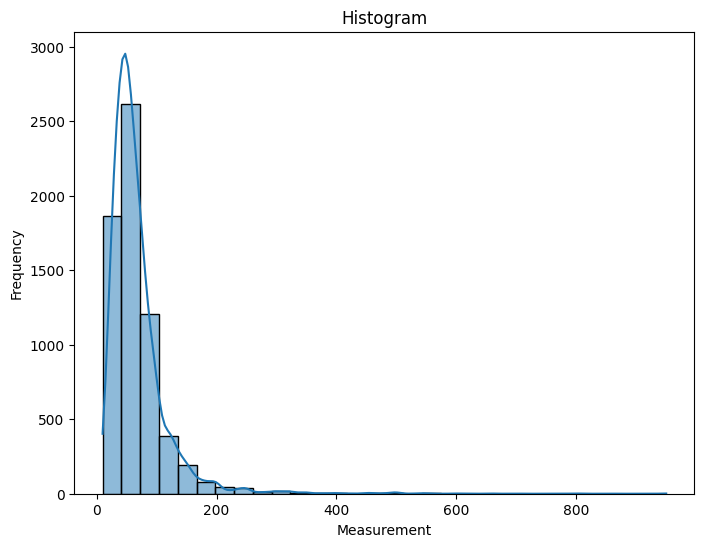

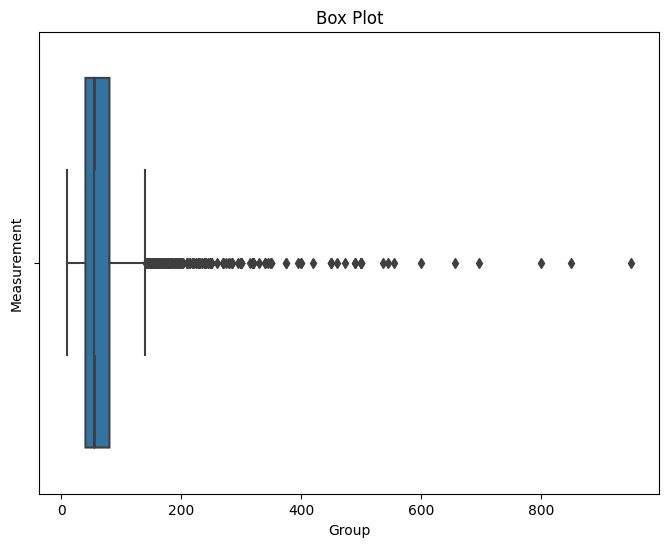

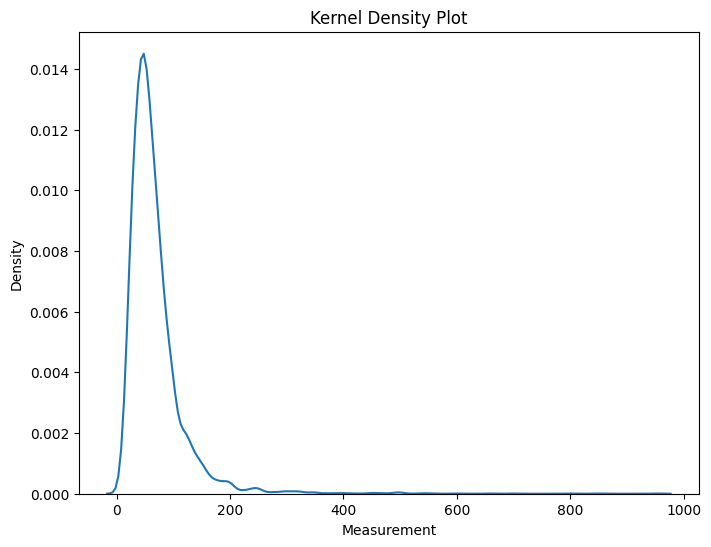

In [156]:
# Univariate analysis on the target variable 
univariate_plotting(df, "target") # For information on the additional features, the name of the target must be specified

In [157]:
def scatterplots(df, numerical_features, target_feature):
    for feature in numerical_features:
        if feature != target_feature:
            plt.figure()
            plt.scatter(df[feature], df[target_feature])
            plt.xlabel(feature)
            plt.ylabel(target_feature)
            plt.title(f"Scatterplot: {feature} vs {target_feature}")
            plt.show()

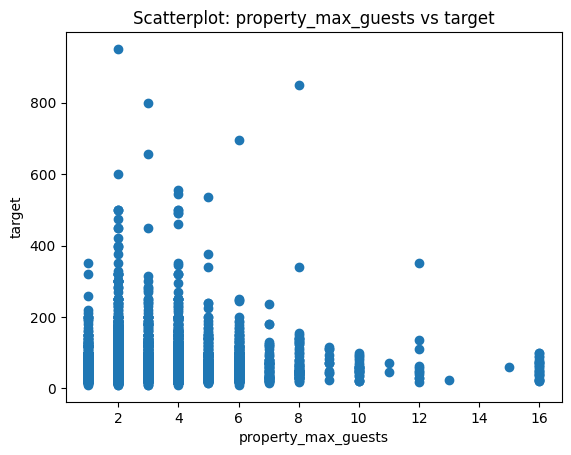

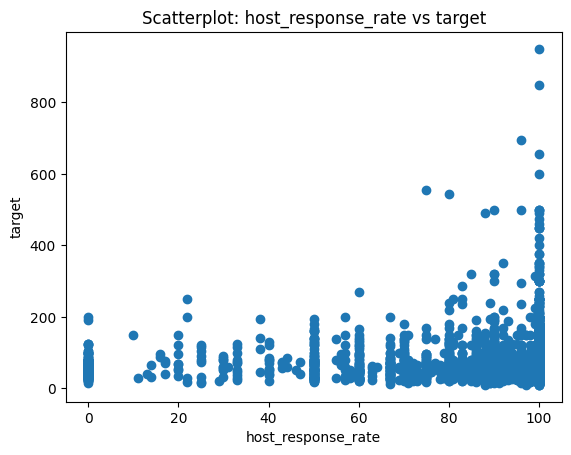

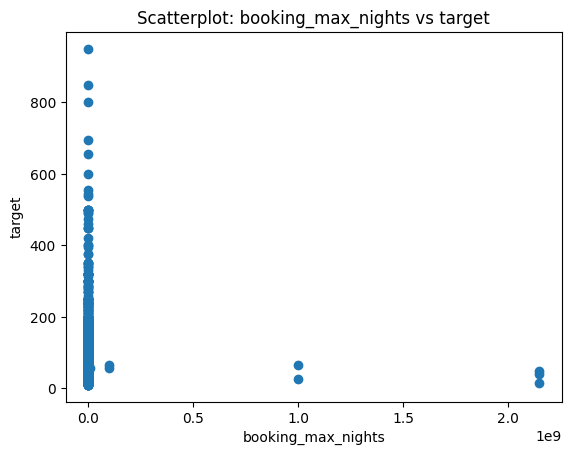

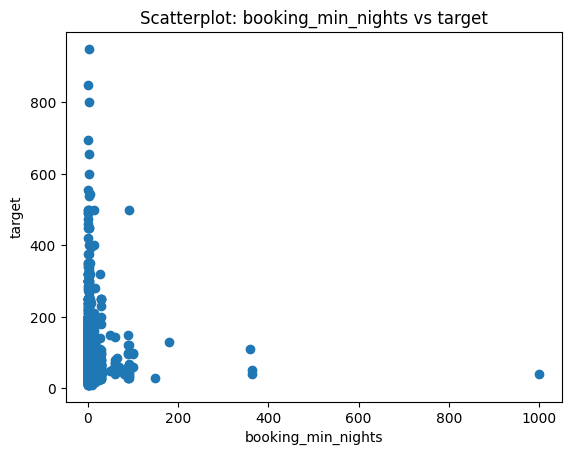

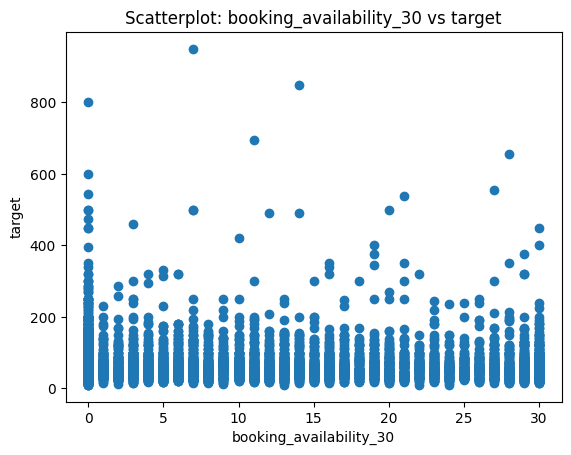

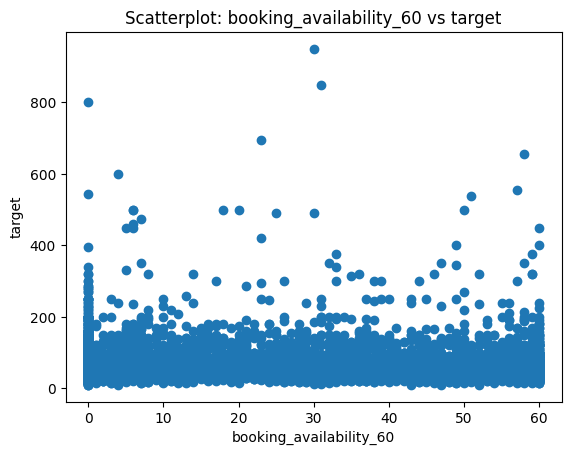

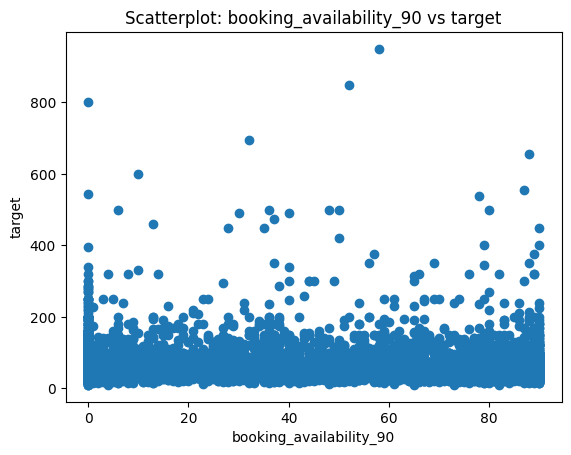

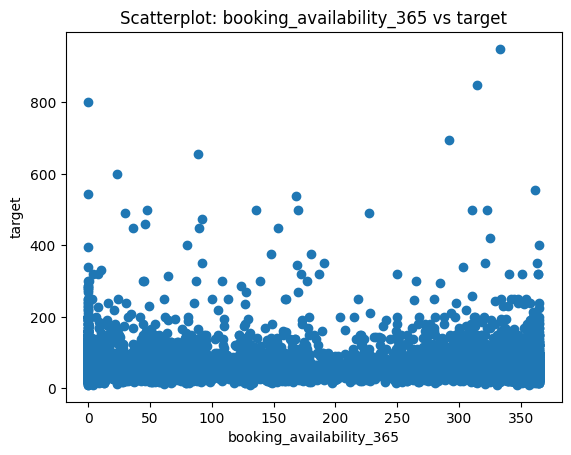

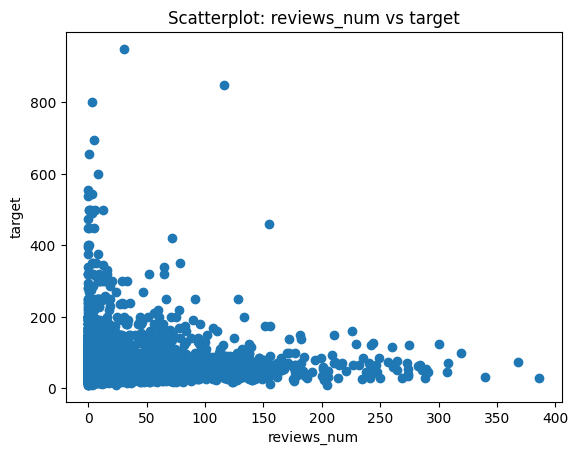

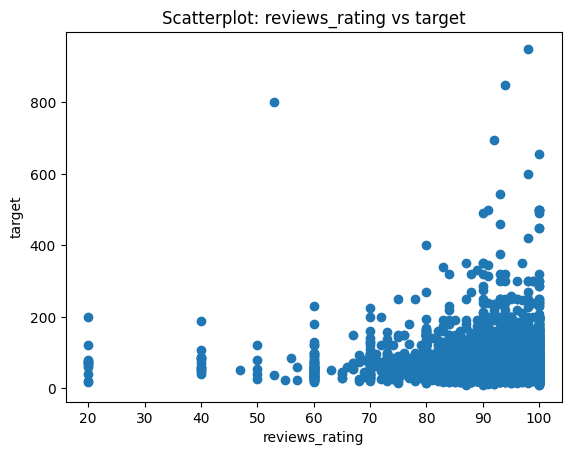

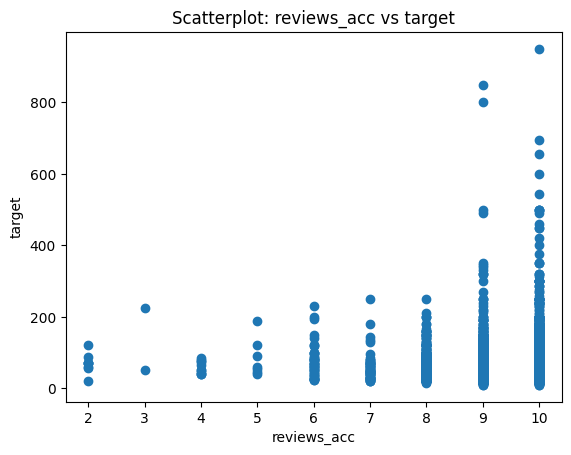

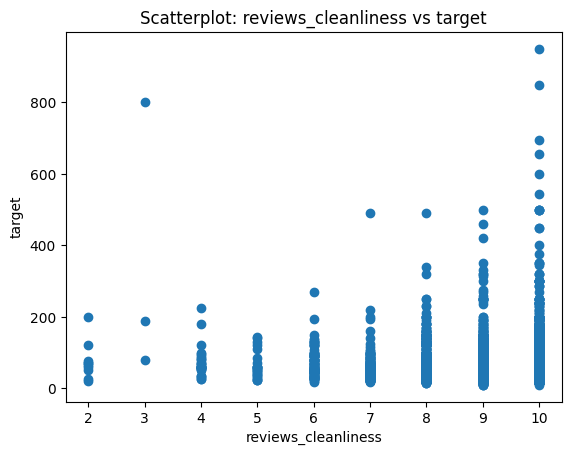

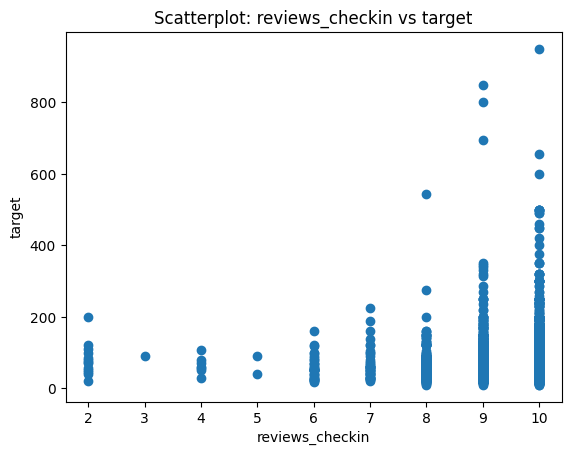

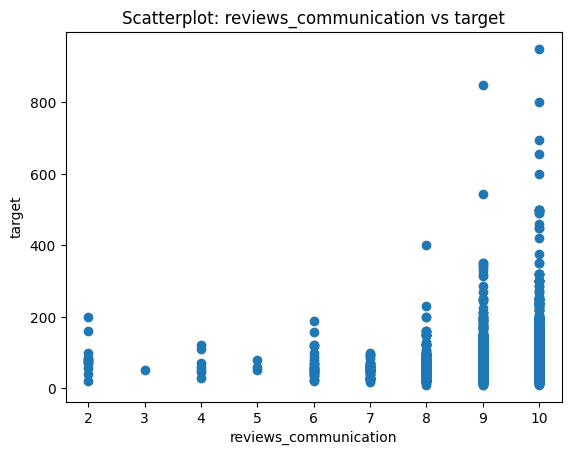

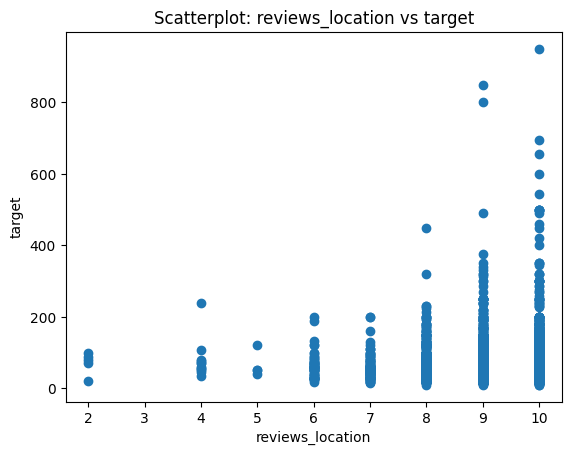

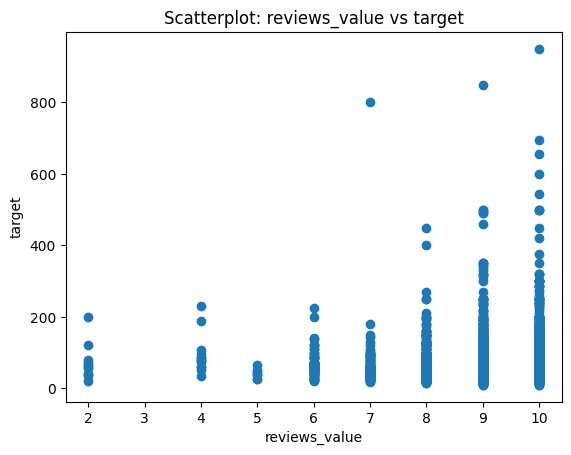

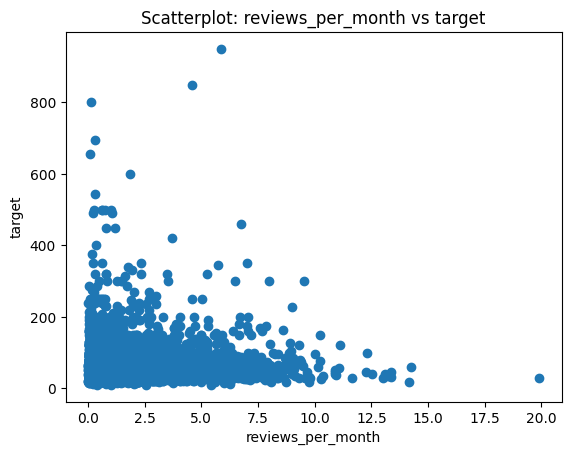

In [158]:
scatterplots(df, numerical_features, 'target')

### Exploring correlations and associations 

Correlation Matrix:
                           property_max_guests  host_response_rate  booking_max_nights  booking_min_nights  booking_availability_30  booking_availability_60  booking_availability_90  booking_availability_365  reviews_num  reviews_rating  reviews_acc  reviews_cleanliness  reviews_checkin  reviews_communication  reviews_location  reviews_value  reviews_per_month    target
property_max_guests                  1.000000            0.061773            0.022501           -0.023394                 0.037073                 0.036343                 0.030952                  0.080033     0.057177       -0.036613    -0.044361            -0.040600        -0.027932              -0.023900         -0.015755      -0.054618          -0.007558  0.013431
host_response_rate                   0.061773            1.000000            0.005809            0.012945                -0.172297                -0.155004                -0.156057                 -0.100113     0.127008        0.067458

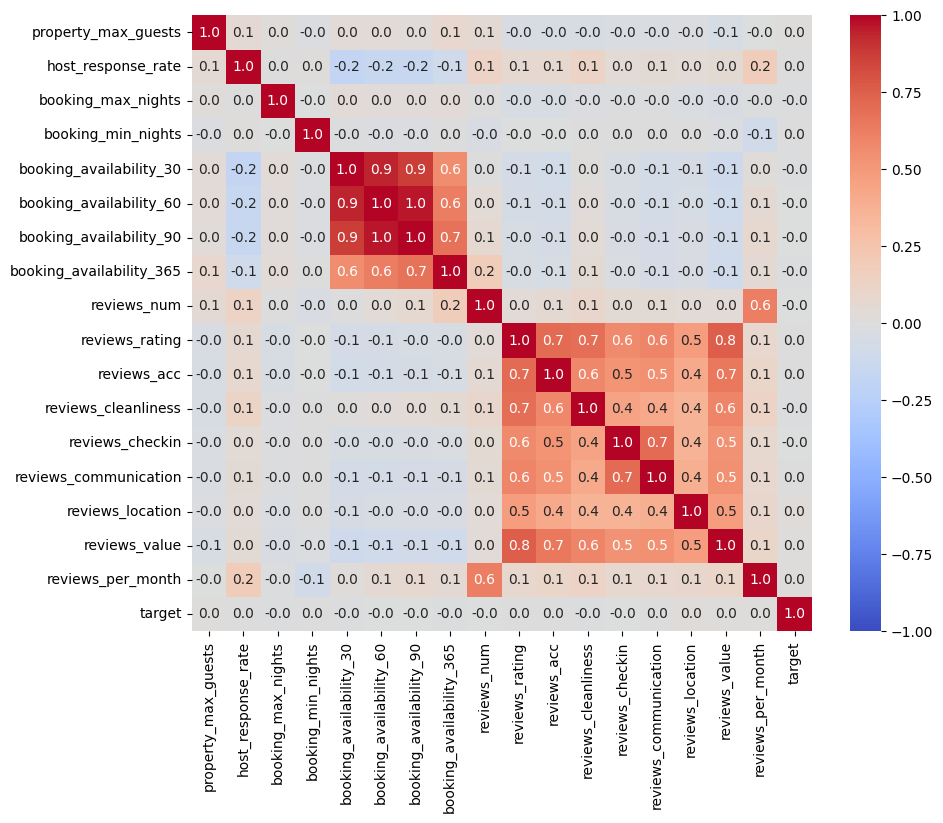

In [159]:
# Getting the correlations on numerical features
numeric_corr_target = correlation_heatmap(df[numerical_features])

### Exploring outliers


In [160]:
# Count the number of observations greater than 200 in the target variable
count = len(df[df['target'] > 200])

# Print the count
print(count)

114


For outlier exploration in more detail refer to the section on preprocessing, specifically dealing with outliers. The LOC developed further is performed on a complete data set, after dealing with missing values. 

### Exploring missingness

In [161]:
# Renaming missing values 
df = df.replace('', np.NaN)
# Getting the total missing values
print("{} missing values within the dataset.".format(df.isna().sum().sum())) 

48444 missing values within the dataset.


The following object collects the # of missing values within a feature and the rate of missingness within each feature

In [162]:
# Applying function for identifying missing rates on features
features_missing = features_missing_values(df)
print(features_missing)

                          Total Missing  Percentage (%)
Feature                                                
property_sqfeet                    6333              97
property_notes                     4522              69
property_interaction               3404              52
property_rules                     3169              48
property_access                    3135              48
host_about                         3107              47
property_neighborhood              2811              43
property_transit                   2580              39
property_space                     2309              35
host_response_rate                 1461              22
host_response_time                 1461              22
reviews_value                      1405              21
reviews_location                   1403              21
reviews_checkin                    1401              21
reviews_acc                        1399              21
reviews_cleanliness                1397         

Now, the names of features with a high rate of missigness (>0.5) are going to be collected into a dataframe. They will be used later on when dealing with missignness (you can refer to data cleaning section). 

In [163]:
def features_missing_values(df, threshold=5):
    missing = df.isnull().sum() # Identifying missing sum within each feature
    missing_pct = (missing / len(df)) * 100 # Percentage of missingness compare to total n in dataset
    missing_values = pd.concat([
        missing, missing_pct.astype('int64')], # Getting type int64 for Percentage column 
        axis=1, 
        keys=[
            'Total Missing', 'Percentage (%)']
     ) # Creating dataframe with % of missing for each feature
    missing_values.sort_values(by='Total Missing', ascending=False, inplace=True) # Sorting
    missing_values.index.name = 'Feature' # Setting the index as 'Feature'
    return missing_values[missing_values['Percentage (%)'] > threshold].index.tolist()

In [164]:
features_miss_05 = features_missing_values(df)

In [165]:
features_miss_05

['property_sqfeet',
 'property_notes',
 'property_interaction',
 'property_rules',
 'property_access',
 'host_about',
 'property_neighborhood',
 'property_transit',
 'property_space',
 'host_response_rate',
 'host_response_time',
 'reviews_value',
 'reviews_location',
 'reviews_checkin',
 'reviews_acc',
 'reviews_cleanliness',
 'reviews_communication',
 'reviews_rating',
 'reviews_per_month',
 'reviews_last',
 'reviews_first']

In [166]:
def instances_missing_rate(df):
    # Calculate missing value rate for each instance
    missing_rate_instance = df.isna().sum(axis=1) / df.shape[1]
    # Create dataframe with missing value rate for each instance
    df_missing_rate = pd.DataFrame({'Instance': df.index, 'Missing_Rate': missing_rate_instance})
    return df_missing_rate

In [167]:
df_missing = instances_missing_rate(df)

df_filtered = df_missing[df_missing['Missing_Rate'] > 0.1]

In [168]:
print(df_filtered)

      Instance  Missing_Rate
0            0      0.127273
18          18      0.163636
19          19      0.109091
21          21      0.145455
22          22      0.163636
...        ...           ...
6488      6488      0.363636
6491      6491      0.254545
6492      6492      0.290909
6493      6493      0.109091
6494      6494      0.254545

[3439 rows x 2 columns]


##### Visualization of missingness patterns

<Axes: >

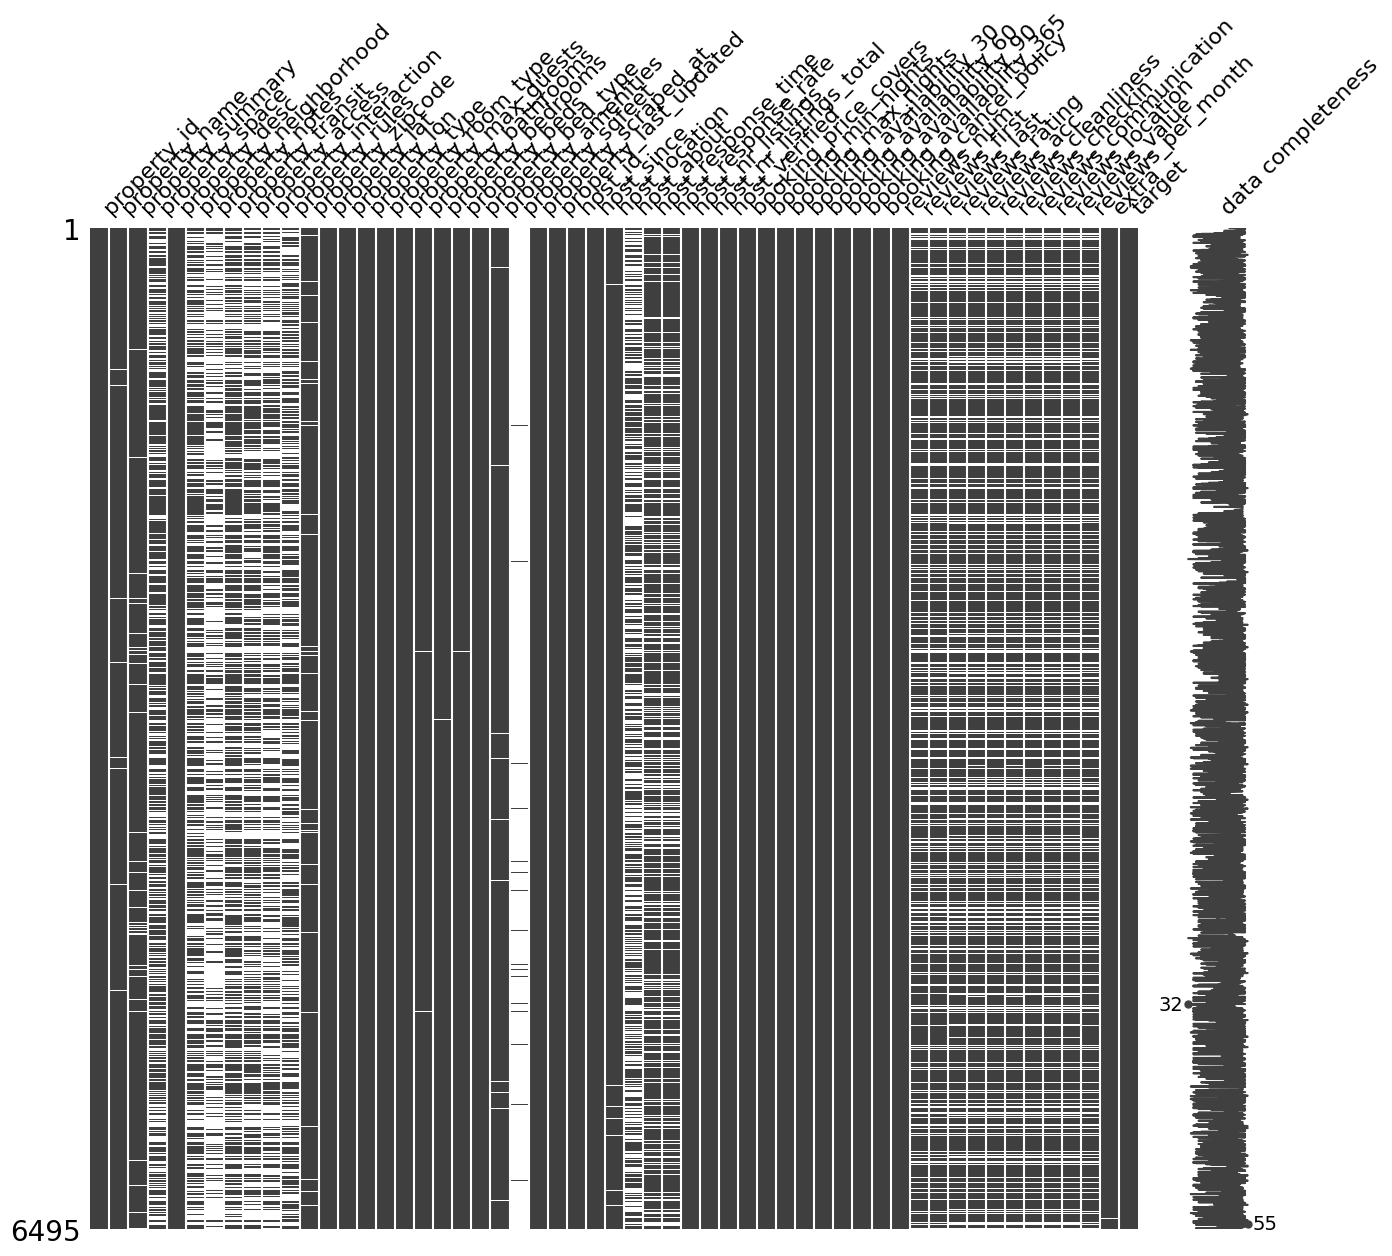

In [169]:
# Missingness matrix
msno.matrix(df, figsize = (15, 13),  labels=True)

<Axes: >

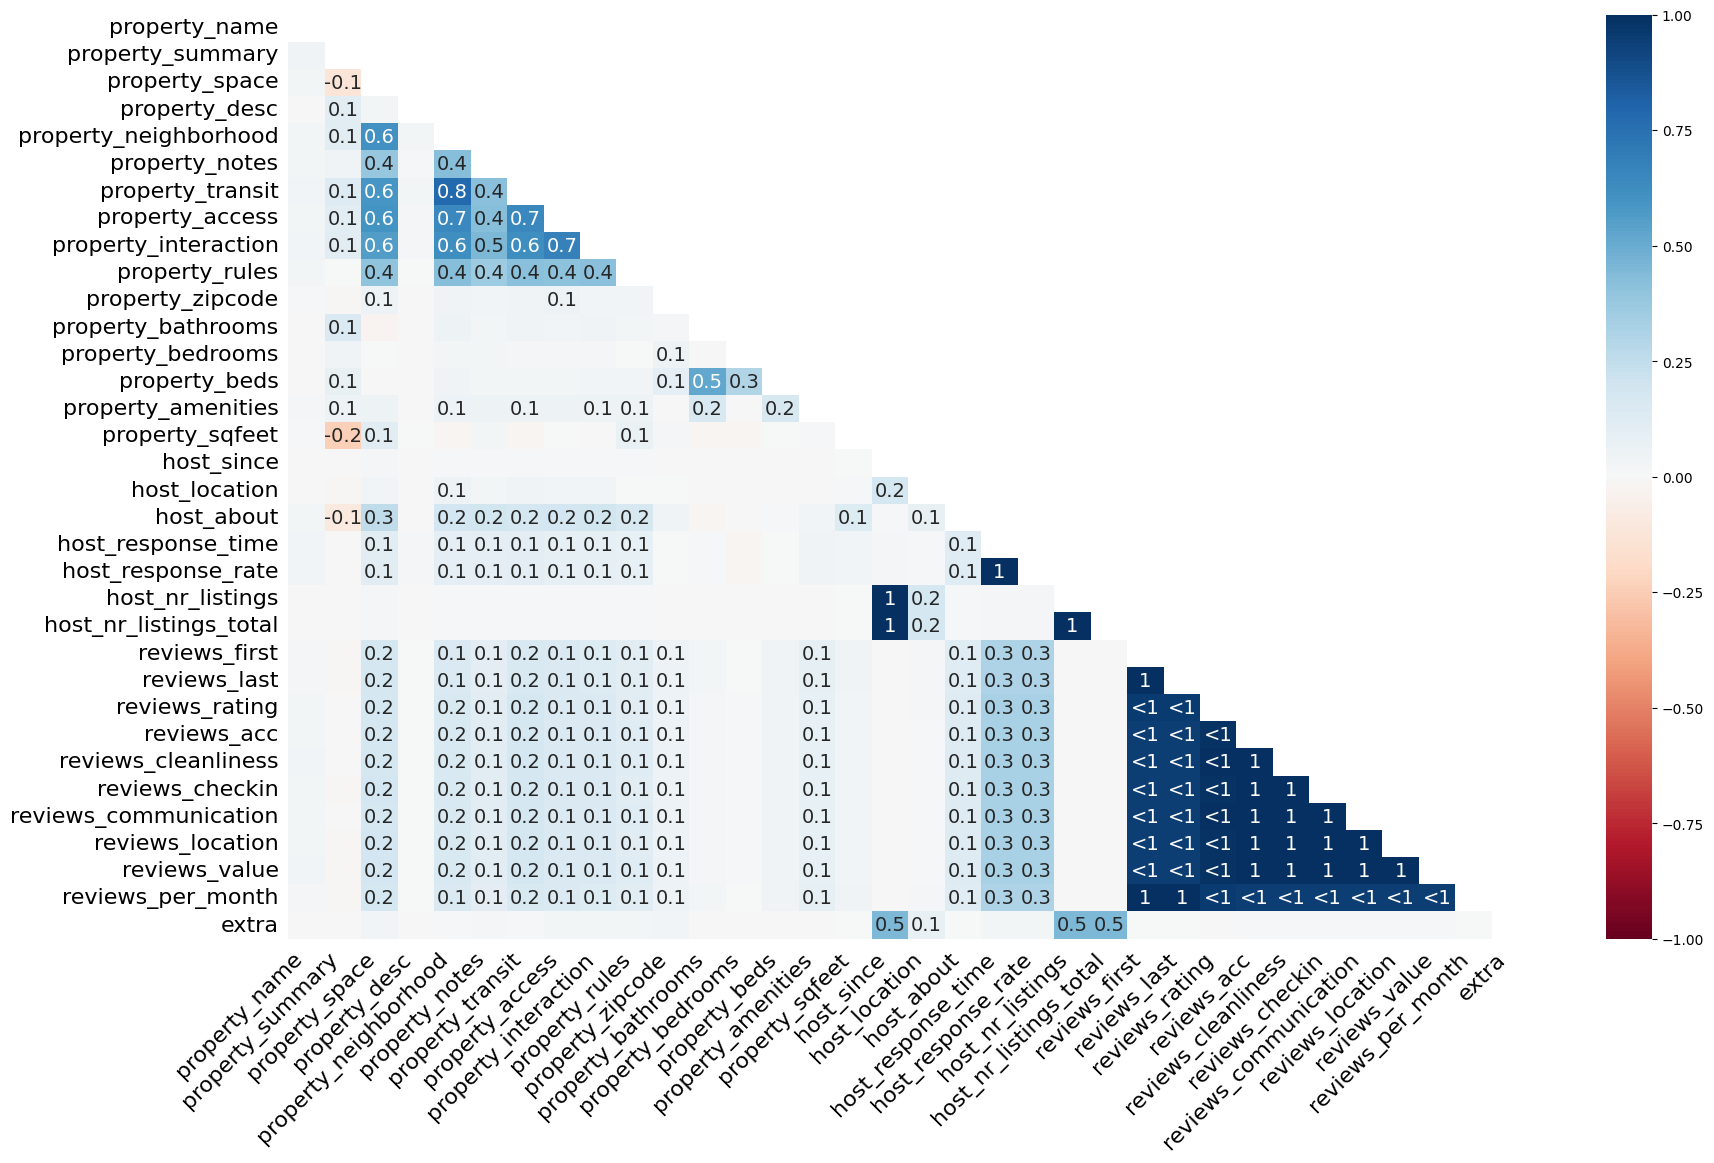

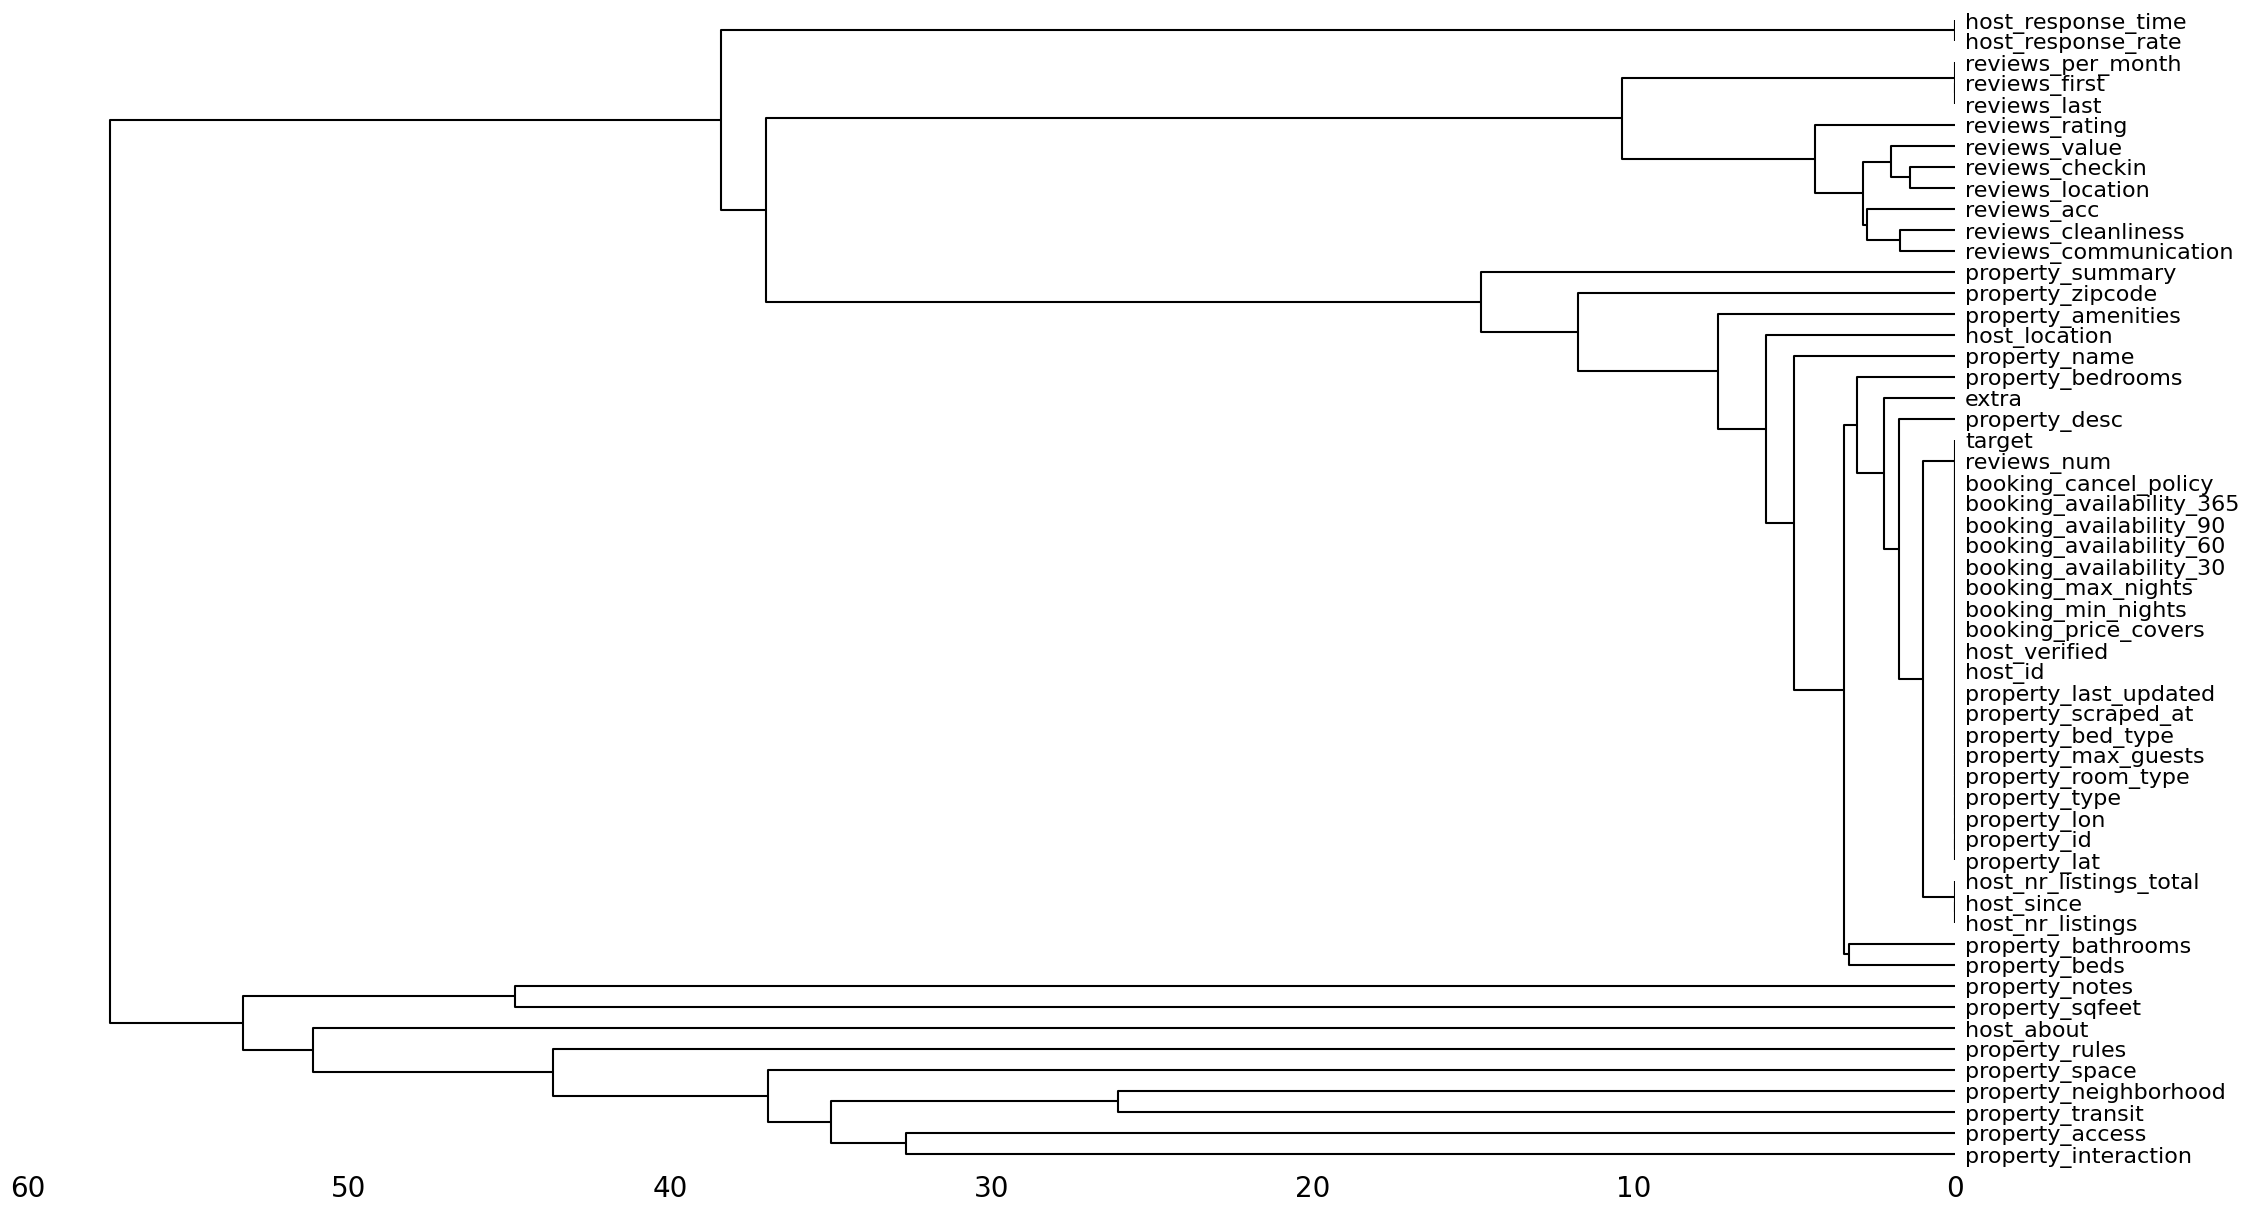

In [170]:
# Missingness nullity correlation
msno.heatmap(df)
# Missingness in dendogram
msno.dendrogram(df)

### Exploring specific features 

Correlation Matrix:
                        reviews_acc  reviews_cleanliness  reviews_checkin  reviews_communication  reviews_location  reviews_value    target
reviews_acc               1.000000             0.585458         0.530873               0.546245          0.421839       0.655144  0.007178
reviews_cleanliness       0.585458             1.000000         0.446029               0.417214          0.362157       0.600849 -0.008724
reviews_checkin           0.530873             0.446029         1.000000               0.710316          0.362900       0.534641 -0.001127
reviews_communication     0.546245             0.417214         0.710316               1.000000          0.385512       0.544665  0.000777
reviews_location          0.421839             0.362157         0.362900               0.385512          1.000000       0.482543  0.022843
reviews_value             0.655144             0.600849         0.534641               0.544665          0.482543       1.000000  0.010774
target

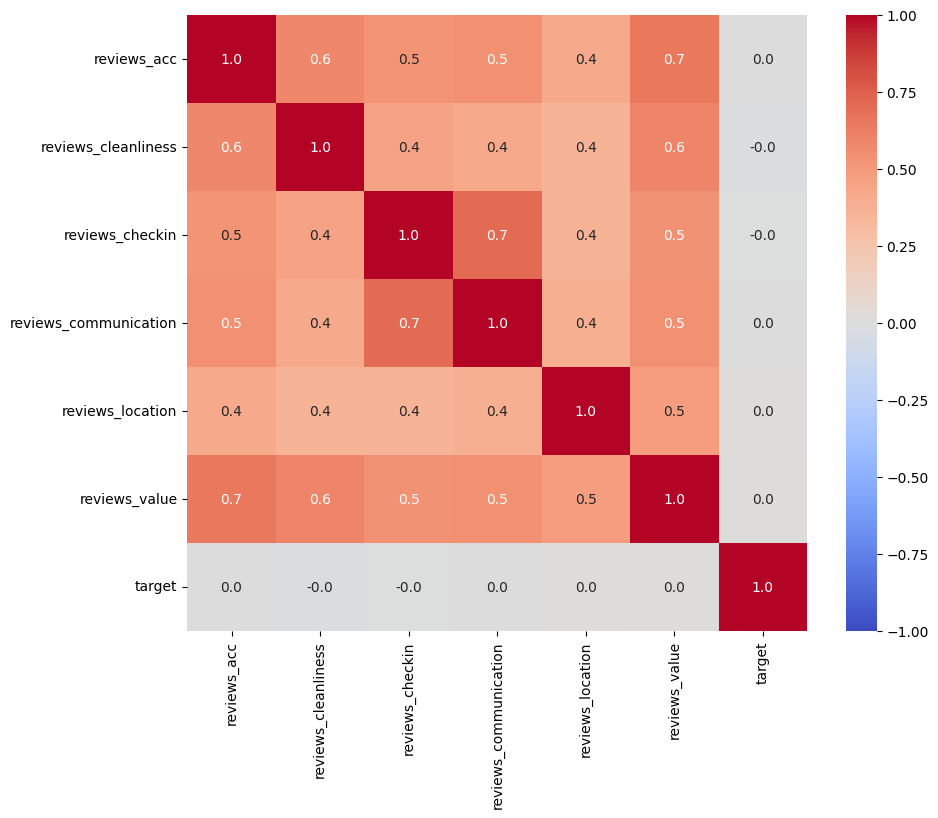

In [171]:
# Reviews features
reviews = df[['reviews_acc', 'reviews_cleanliness', 'reviews_checkin', 'reviews_communication', 'reviews_location', 'reviews_value', 'target']]
# Getting and visualizing correlations with a heatmap and the correlation matrix
correlation_heatmap(reviews)

Correlation Matrix:
                           booking_price_covers  booking_min_nights  booking_max_nights  booking_availability_30  booking_availability_60  booking_availability_90  booking_availability_365    target
booking_price_covers                  1.000000           -0.017056            0.036342                 0.030272                 0.033760                 0.034626                  0.094798  0.007298
booking_min_nights                   -0.017056            1.000000           -0.002517                -0.014277                -0.020149                -0.018130                  0.001203  0.007518
booking_max_nights                    0.036342           -0.002517            1.000000                 0.032001                 0.029997                 0.028729                  0.033063 -0.015577
booking_availability_30               0.030272           -0.014277            0.032001                 1.000000                 0.938763                 0.870376                  0.557821

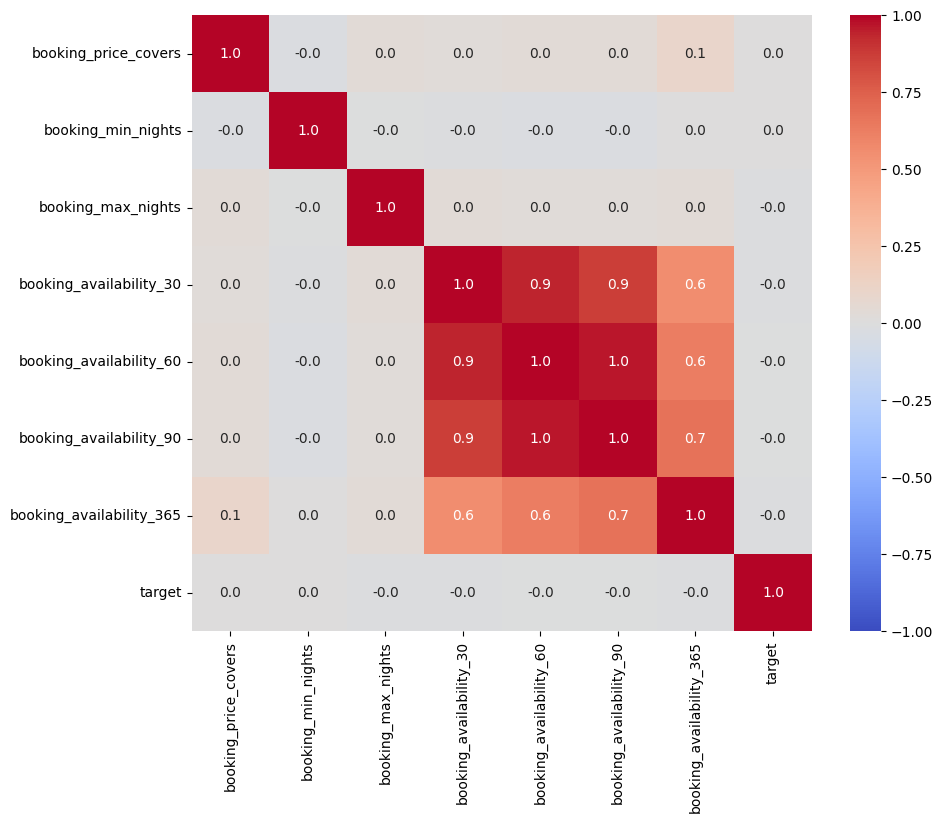

In [172]:
# Booking features
bookings = df[['booking_price_covers', 'booking_min_nights',
       'booking_max_nights', 'booking_availability_30',
       'booking_availability_60', 'booking_availability_90',
       'booking_availability_365', 'target']]
# Getting and visualizing correlations with a heatmap and the correlation matrix
correlation_heatmap(bookings)

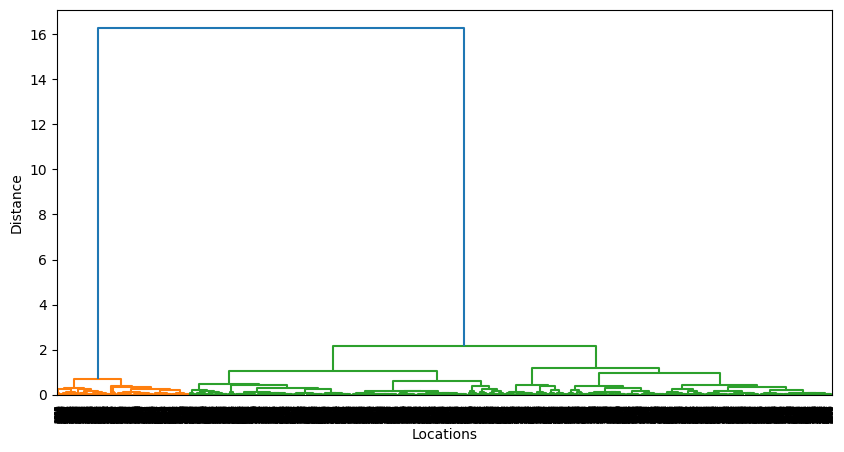

In [173]:
locations = df[['property_lat', 'property_lon']]
plot_dendrogram(locations)

### Using profiling report

Uncoment this section for using profiling report

In [174]:
# # Profile report
# from ydata_profiling import ProfileReport
# from ydata_profiling.utils.cache import cache_file
# profile1 = ProfileReport(
#     df, title="Exploratory Data Analysis: airbnb", html={"style": {"full_width": True}}, sort=None
# )

In [175]:
# # Report using profiling 
# profile1.to_notebook_iframe()
# profile1.to_file("EDA_tabular_final.html")
# # upload HTML file to Google Drive folder
# folder_id = 'data_1'
# file_name = 'EDA_tabular_final.html'
# file_path = '/content/drive/MyDrive/analytics/data_1/EDA_tabular.html' # add specific path
# destination_folder = '/content/drive/MyDrive/analytics/data_1/{}'.format(folder_id) # add specific path
# os.makedirs(destination_folder, exist_ok=True)
# !cp "$file_path" "$destination_folder/{file_name}" 

When using Google Collab, to the get the Exploratory Data Analysis report is necessary to store a html file and then download it. It's because of the size of the file.

# Preprocessing


## Data Cleaning and data consistency


In [176]:
# Making values from zipcode uniform
df = convert_zipcode(df)

In [177]:
duplicate_features(df)

Feature 'host_nr_listings_total' is duplicated.


In [178]:
df = df.drop('host_nr_listings_total', axis=1)

## Dealing with missigness

In [179]:
identify_missing_features(df, threshold=0.9)

The following features have a missing rate greater than 90.0%:
- property_sqfeet


In [180]:
df = df.drop('property_sqfeet', axis=1)

In [181]:
df_imputed = impute_missing_values(df)

## Dealing with outliers

In [182]:
# Perform one-hot encoding and outlier detection
df_out = perform_outlier_detection(df_imputed, numerical_features, categorical_features, text_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [183]:
# count the unique values of a feature
unique_counts = df_out['is_outlier'].value_counts()

# print the unique value counts
print(unique_counts)

 1    6365
-1     130
Name: is_outlier, dtype: int64


In [184]:
removed_rows = df_out[df_out['is_outlier'] == -1].index.tolist()
df_out = df_out[df_out['is_outlier'] != -1]
df_imputed = df_imputed.drop(removed_rows)
df = df_imputed
print("Removed rows:")
print(removed_rows)

Removed rows:
[26, 195, 199, 244, 245, 275, 357, 383, 442, 450, 511, 583, 661, 721, 814, 818, 916, 1015, 1199, 1263, 1283, 1284, 1285, 1295, 1326, 1386, 1395, 1396, 1397, 1398, 1399, 1416, 1435, 1469, 1505, 1648, 1701, 1895, 1940, 1970, 1987, 1988, 2033, 2095, 2131, 2135, 2137, 2184, 2198, 2199, 2263, 2299, 2311, 2413, 2422, 2487, 2488, 2574, 2590, 2768, 2805, 2809, 2859, 2939, 3019, 3096, 3104, 3137, 3200, 3201, 3202, 3586, 3606, 3661, 3744, 3753, 3918, 3981, 4111, 4388, 4430, 4432, 4481, 4544, 4545, 4589, 4639, 4642, 4653, 4716, 4802, 4900, 4994, 5187, 5272, 5310, 5311, 5316, 5317, 5318, 5397, 5445, 5458, 5506, 5525, 5529, 5530, 5598, 5599, 5614, 5644, 5848, 5949, 5953, 5954, 5959, 5961, 6008, 6051, 6084, 6113, 6162, 6198, 6200, 6201, 6202, 6233, 6329, 6347, 6365]


Uncoment if you want to perform it on obs <200 for the target

In [185]:
# df = df[df['target'] <= 200]

## Creating features

In [186]:
# Condition to check for text by row
has_text = df[text_columns].apply(lambda row: 0 if any(pd.isna(row)) or any(row == ' ') or any(row == ' ') else 1, axis=1)

# Assign value to text_var based on the condition
df['text_var'] = has_text

In [187]:
df['text_var'].value_counts()

0    5260
1    1105
Name: text_var, dtype: int64

In [188]:
# encode property_room_type into entire home/apt vs other
def binary_property_room_type(row):
    if row['property_room_type'] == 'Entire home/apt': 
        return 1
    else:
        return 0 
df['property_room_type'] = df.apply(lambda x: binary_property_room_type(x), axis=1)

print(df.property_room_type)

0       0
1       1
2       1
3       0
4       0
       ..
6490    0
6491    0
6492    0
6493    0
6494    1
Name: property_room_type, Length: 6365, dtype: int64


In [189]:
# Setting an index for reviews: 'reviews_acc', 'reviews_cleanliness', 'reviews_checkin', 'reviews_communication', 'reviews_location', 'reviews_value'
df['reviews_avg'] = df[['reviews_acc', 'reviews_cleanliness', 'reviews_checkin', 'reviews_communication', 'reviews_location', 'reviews_value']].mean(axis=1)
print(df.reviews_avg)

0        9.666667
1        9.666667
2        9.500000
3       10.000000
4       10.000000
          ...    
6490    10.000000
6491     9.533333
6492     9.500000
6493     9.666667
6494     9.400000
Name: reviews_avg, Length: 6365, dtype: float64


In [190]:
df = add_zipcode2_column(df)

Column 'zipcode2' added to DataFrame.


In [191]:
df = city(df)

In [192]:
add_and_populate_columns_for_extras(df)

['Host Has Profile Pic', 'Is Location Exact', 'Instant Bookable', 'Host Is Superhost', 'Host Identity Verified', 'Require Guest Phone Verification', 'Require Guest Profile Picture']


In [193]:
df['city'].value_counts()

Brussels    5310
Antwerp     1055
Name: city, dtype: int64

In [194]:
from geopy.distance import geodesic

def add_distance_to_city_center(df, city_center_coords, city_column='city'):
    for city, coords in city_center_coords.items():
        city_mask = df[city_column] == city
        df.loc[city_mask, 'distance_to_city_center'] = df[city_mask].apply(
            lambda row: geodesic((row['property_lat'], row['property_lon']), coords).kilometers,
            axis=1
        )

# Usage example
city_center_coords = {
    'Brussels': (50.8503, 4.3517),
    'Antwerp': (51.2194, 4.4025)
}

add_distance_to_city_center(df, city_center_coords)

In [195]:
columns_to_check = ['dummy_extra_Is Location Exact', 'dummy_extra_Instant Bookable', 'dummy_extra_Host Identity Verified', 'dummy_extra_Host Is Superhost']
new_column_name = 'ext'

df = create_combined_boolean_column(df, columns_to_check, new_column_name)

In [196]:
df = group_rooms(df)

In [197]:
from datetime import datetime

def calculate_host_duration(df, host_since_column='host_since'):
    # Convert the host start dates to datetime objects
    df[host_since_column] = pd.to_datetime(df[host_since_column])

    # Calculate the duration by subtracting the host start dates from the current date
    df['host_duration'] = (datetime.now() - df[host_since_column]).dt.days

    return df

In [198]:
df = calculate_host_duration(df)

In [199]:
df = calculate_guests_to_rooms_ratio(df)

In [200]:
df = group_property_amenities(df)

In [201]:
def calculate_booking_rate(df):
    df['booking_rate'] = df['booking_max_nights'] - df['booking_min_nights'] / df['booking_availability_365']
    df['booking_rate'] = df['booking_rate'].replace([np.inf, -np.inf], 0)
    return df

In [202]:
df = calculate_booking_rate(df)

## Set up

In [237]:
set_up = df[[
    'reviews_avg', 'booking_rate', 'reviews_per_month', 'guests_to_rooms_ratio', 'host_response_rate', 'host_duration', 'distance_to_city_center',
    'room_configuration', 'property_room_type', 'Entertainment', 'Pets',
     'target']]

<ipython-input-134-19b3db01909a>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Correlation Matrix:
                          reviews_avg  booking_rate  reviews_per_month  guests_to_rooms_ratio  host_response_rate  host_duration  distance_to_city_center  property_room_type  Entertainment    target
reviews_avg                 1.000000      0.022530           0.144573              -0.014054            0.087807       0.024980                -0.002630            0.016917       0.031564  0.021008
booking_rate                0.022530      1.000000           0.198142               0.082192            0.002038      -0.018877                -0.053251            0.048310       0.074517  0.008375
reviews_per_month           0.144573      0.198142           1.000000               0.085286            0.171100      -0.118310                -0.078140           -0.001838       0.012313  0.004209
guests_to_rooms_ratio      -0.014054      0.082192           0.085286               1.000000            0.076073       0.020228                -0.087061            0.361891       0.112276

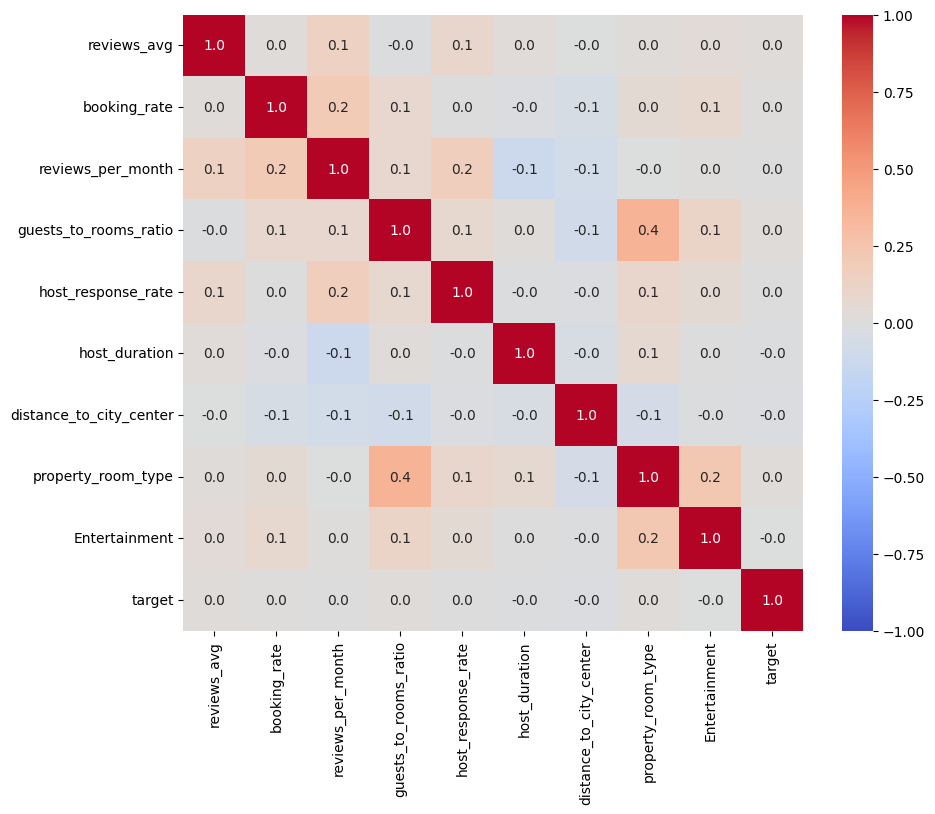

In [204]:
final_corr = correlation_heatmap(set_up)

In [205]:
# set_up.to_csv("/content/drive/MyDrive/analytics/data_1/set_up.csv") # add specific path

In [238]:
# Extracting correct features
from sklearn.model_selection import train_test_split
X = set_up.drop('target', axis=1)
Y = set_up['target']

# # Splitting data into train data and validation data 

X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=1)

# Data Analysis: training the model

## Linear Regression

In [239]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import NotFittedError

# Define numeric and categorical features
numeric_features = [
'reviews_avg', 'booking_rate', 'reviews_per_month', 'guests_to_rooms_ratio', 'host_response_rate', 'host_duration', 'distance_to_city_center',
]
categoric_features = [
'room_configuration', 'property_room_type', 'Entertainment','Pets'
]
if 'target' in numeric_features:
    numeric_features.remove('target')
# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ])

# Create pipeline with preprocessor and ridge regression

lr = Pipeline(steps=[    ('preprocessor', preprocessor),    ('regressor', LinearRegression())])


# Fit the pipeline on the training data
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reviews_avg',
                                                   'booking_rate',
                                                   'reviews_per_month',
                                                   'guests_to_rooms_ratio',
                                                   'host_response_rate',
                                                   'host_duration',
                                                   'distance_to_city_center']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room_configuration',
                                                   'property_room_type',
                                                   'Entertainment',
                                                   'Pets'])])),
                ('regressor', LinearRegression())])

In [240]:
# Make predictions on the test data
y_pred_lr = np.round(lr.predict(X_test))

## Random Forest Regressor

In [260]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import NotFittedError
from sklearn.inspection import permutation_importance

# Define numeric and categorical features
numeric_features = [
'reviews_avg', 'booking_rate', 'reviews_per_month', 'guests_to_rooms_ratio', 'host_response_rate', 'host_duration', 'distance_to_city_center',
]
categoric_features = [
'room_configuration', 'property_room_type', 'Entertainment','Pets'
]
if 'target' in numeric_features:
    numeric_features.remove('target')
# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ])


# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ],
    sparse_threshold=0
)

# Create pipeline with preprocessor and random forest regressor
rfr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, max_depth=15,n_estimators=150))
])

# Fit the pipeline on the training data
rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reviews_avg',
                                                   'booking_rate',
                                                   'reviews_per_month',
                                                   'guests_to_rooms_ratio',
                                                   'host_response_rate',
                                                   'host_duration',
                                                   'distance_to_city_center']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room_configuration',
                                                   'property_room_type',
                                                   'Entertainment',
                                                   'Pets'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=15, n_estimators=150,
                                       random_state=42))])

In [242]:
# Make predictions on the test data
y_pred_rfr = rfr.predict(X_test)

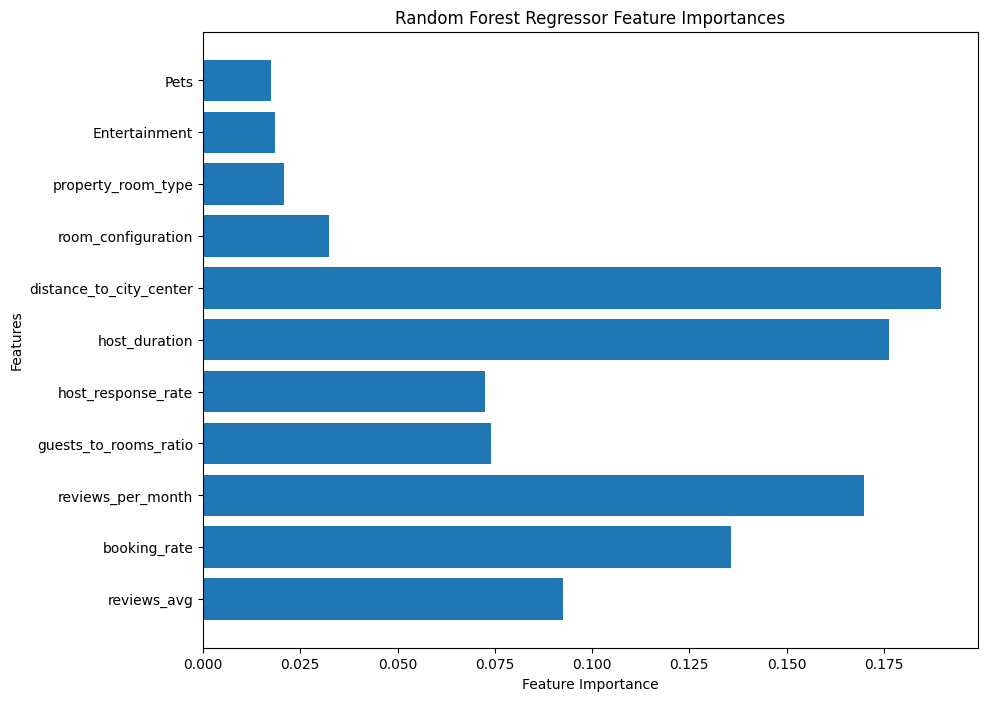

In [243]:
# Fit the OneHotEncoder transformer to the categorical features
categoric_transformer.fit(X_train[categoric_features])

# Get feature importances and names
importances = rfr.named_steps['regressor'].feature_importances_
encoded_cat_features = categoric_transformer.named_steps['onehot'].get_feature_names_out(categoric_features)
all_feature_names = numeric_features + list(encoded_cat_features)
feature_importances = np.zeros(len(all_feature_names))

# Add the importances of the original numeric features
feature_importances[:len(numeric_features)] += importances[:len(numeric_features)]

# Combine the importances of the encoded categorical features into the original features
feature_importances = importances[:len(numeric_features)].tolist()  # Start with the numeric features
for i, feature_name in enumerate(categoric_features):
    encoded_cat_importances = [
        importances[j] for j, feat_name in enumerate(all_feature_names)
        if feat_name.startswith(feature_name + '_')
    ]
    feature_importances.append(sum(encoded_cat_importances))

# Get the names of the original features
original_feature_names = numeric_features + categoric_features

# Plot the feature importances
plt.figure(figsize=(10,8))
plt.barh(original_feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Regressor Feature Importances')
plt.show()

## HistGradientBoostRegressor

In [269]:
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.exceptions import NotFittedError


# Define numeric and categorical features
numeric_features = [
'reviews_avg', 'booking_rate', 'reviews_per_month', 'guests_to_rooms_ratio', 'host_response_rate', 'host_duration', 'distance_to_city_center',
]
categoric_features = [
'room_configuration', 'property_room_type', 'Entertainment','Pets'
]
if 'target' in numeric_features:
    numeric_features.remove('target')
# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ])


# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ],
    sparse_threshold=0
)

# Create pipeline with preprocessor and HistGradientBoostingRegressor
hgr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(max_iter=150, max_leaf_nodes=5, max_depth=10, l2_regularization=0.3))
])

# Fit the pipeline on the training data
hgr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reviews_avg',
                                                   'booking_rate',
                                                   'reviews_per_month',
                                                   'guests_to_rooms_ratio',
                                                   'host_response_rate',
                                                   'host_duration',
                                                   'distance_to_city_center']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room_configuration',
                                                   'property_room_type',
                                                   'Entertainment',
                                                   'Pets'])])),
                ('regressor',
                 HistGradientBoostingRegressor(l2_regularization=0.3,
                                               max_depth=10, max_iter=150,
                                               max_leaf_nodes=5))])

In [270]:
# Make predictions on the test data
y_pred_hgr = hgr.predict(X_test)

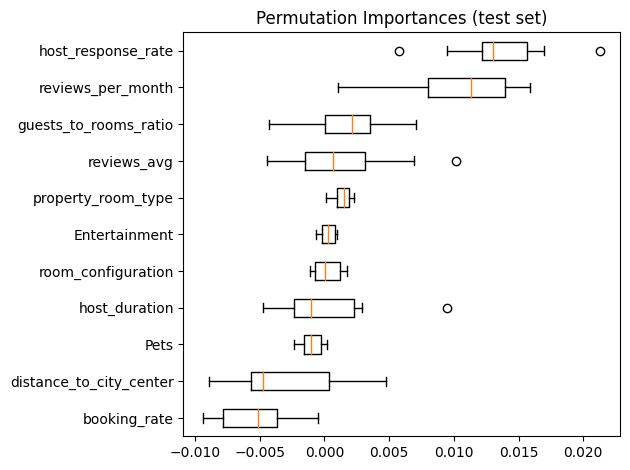

In [271]:
# Get the permutation importances
try:
    result = permutation_importance(hgr, X_test, y_test, n_repeats=10, random_state=42)
except NotFittedError:
    # Handle the case where the model is not fitted
    result = None

if result is not None:
    sorted_idx = result.importances_mean.argsort()

    # Plot the feature importances
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()
else:
    print("Model not fitted.")

## XBoostRegressor

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define numeric and categorical features
numeric_features = [
'reviews_avg', 'booking_rate', 'reviews_per_month', 'guests_to_rooms_ratio', 'host_response_rate', 'host_duration', 'distance_to_city_center',
]
categoric_features = [
'room_configuration', 'property_room_type', 'Entertainment','Pets'
]
if 'target' in numeric_features:
    numeric_features.remove('target')
# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ])


# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ],
    sparse_threshold=0
)

# Create pipeline with preprocessor and XGBRegressor
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(reg_alpha=0.3, reg_lambda=0.5))
])

# Fit the pipeline on the training data
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['reviews_avg',
                                                   'booking_rate',
                                                   'reviews_per_month',
                                                   'guests_to_rooms_ratio',
                                                   'host_response_rate',
                                                   'host_duration',
                                                   'distance_to_city_center']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [273]:
# Make predictions on the test data
y_pred_xgb = xgb.predict(X_test)

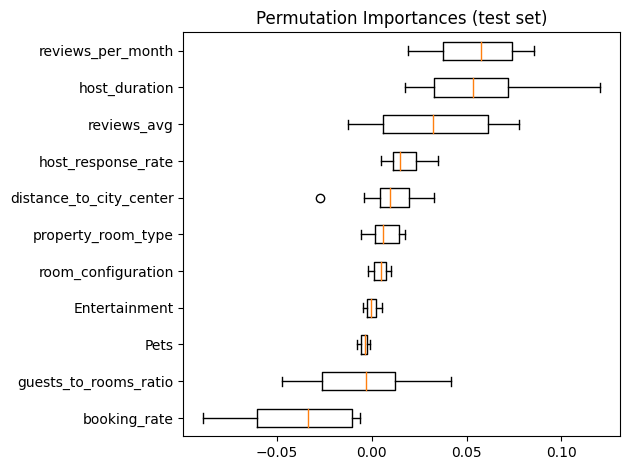

In [274]:
# Get the permutation importances
result = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()

# Plot the feature importances
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Model Evaluation


In [275]:
print("lr evaluation:")
score_estimator(lr, X_test, y_test)
print("RFR evaluation:")
score_estimator(rfr, X_test, y_test)
print("HGBR evaluation:")
score_estimator(hgr, X_test, y_test)
print("XGB evaluation:")
score_estimator(xgb, X_test, y_test)

lr evaluation:
MSE: 2166.231
RMSE: 46.543
MAE: 29.781
RFR evaluation:
MSE: 2235.372
RMSE: 47.280
MAE: 30.731
HGBR evaluation:
MSE: 2198.217
RMSE: 46.885
MAE: 30.068
XGB evaluation:
MSE: 2621.497
RMSE: 51.201
MAE: 32.967


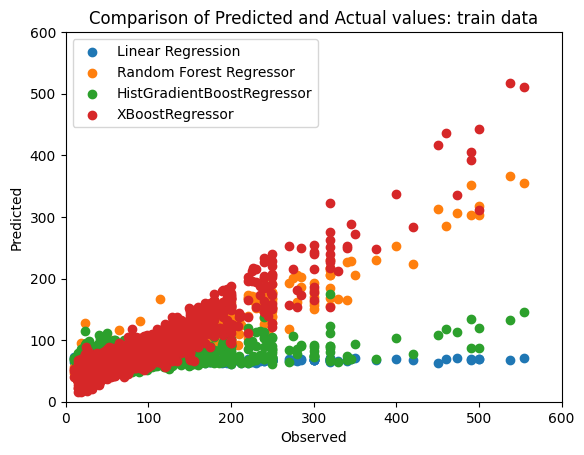

In [276]:
# Comparison of Predicted and Actual values in training data
plt.figure()
plt.title('Comparison of Predicted and Actual values: train data')
plt.scatter(y_train,lr.predict(X_train),label='Linear Regression')
plt.scatter(y_train,rfr.predict(X_train),label='Random Forest Regressor')
plt.scatter(y_train,hgr.predict(X_train),label='HistGradientBoostRegressor')
plt.scatter(y_train,xgb.predict(X_train),label='XBoostRegressor')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.legend()
plt.show()

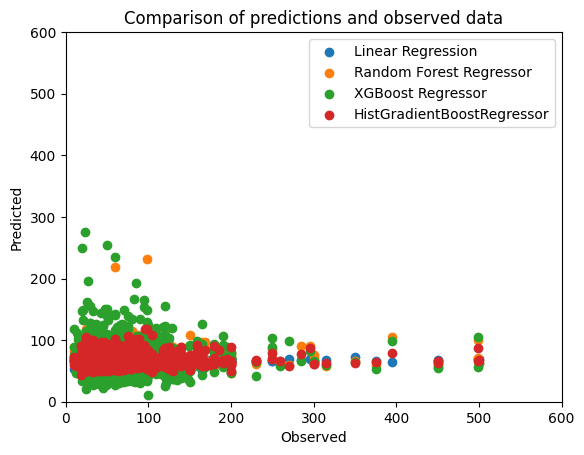

In [277]:
# Make predictions using the trained models
lr_predictions = lr.predict(X_test)
rfr_predictions = rfr.predict(X_test)
hgr_predictions = hgr.predict(X_test)
xgb_predictions = xgb.predict(X_test)

# Plot the comparison of predicted and actual sale prices
plt.figure()
plt.title('Comparison of predictions and observed data')
plt.scatter(y_test, lr_predictions, label='Linear Regression')
plt.scatter(y_test, rfr_predictions, label='Random Forest Regressor')
plt.scatter(y_test, xgb_predictions, label='XGBoost Regressor')
plt.scatter(y_test, hgr_predictions, label='HistGradientBoostRegressor')



plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.legend()
plt.show()

# Hyperparameter tuning

In [220]:
from sklearn.model_selection import GridSearchCV
numeric_features = [
    'reviews_avg', 'booking_max_nights', 'reviews_per_month', 
    'booking_availability_365', 'property_max_guests'
]
categoric_features = [
    'text_var', 'property_beds', 'property_room_type', 'dummy_extra_Is Location Exact',
    'dummy_extra_Instant Bookable', 'dummy_extra_Host Identity Verified', 'city'
]
if 'target' in numeric_features:
    numeric_features.remove('target')

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ],
    sparse_threshold=0
)

model = XGBRegressor()

hyperparameter_grid = {
    'model__n_estimators': [50, 200, 500],
    'model__learning_rate': [0.03, 0.1, 0.3],
    'model__objective': ['reg:squarederror']
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

grid_cv_xgbr = GridSearchCV(estimator=pipeline,
                       param_grid=hyperparameter_grid,
                       scoring='neg_mean_absolute_error',
                       return_train_score=True)

grid_cv_xgbr.fit(X_train, y_train)

ValueError: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV
# Define numeric and categorical features
numeric_features = [
'reviews_avg', 'booking_max_nights', 'reviews_per_month', 
'booking_availability_365', 'property_max_guests', 'host_response_rate'
]
categoric_features = [
'text_var', 'property_beds', 'property_room_type', 'dummy_extra_Is Location Exact',
       'dummy_extra_Instant Bookable',
       'dummy_extra_Host Identity Verified','city'
]
if 'target' in numeric_features:
    numeric_features.remove('target')

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categoric_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categoric_transformer, categoric_features)
    ],
    sparse_threshold=0
)

model = RandomForestRegressor()

# Define the hyperparameter grid
hyperparameter_grid = {
    'model__max_iter': [100, 200, 500],
    'model__max_leaf_nodes': [20, 40, 60],
    'model__learning_rate': [0.1, 0.01, 0.001]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

grid_cv = GridSearchCV(estimator=pipeline,
                       param_grid=hyperparameter_grid,
                       scoring='neg_mean_absolute_error',
                       return_train_score=True)

grid_cv.fit(X_train, y_train)

In [ ]:
# Save the best model
best_model = grid_cv.best_estimator_
# joblib.dump(best_model, 'random_forest_model.pkl')

# Access the best hyperparameters
best_params = grid_cv.best_params_
print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

In [ ]:
# Make predictions using the best model
best_predictions = best_model.predict(X_test)

In [ ]:
# Make predictions using the trained models
lr_predictions = lr.predict(X_test)
rfr_predictions = rfr.predict(X_test)
hgr_predictions = hgr.predict(X_test)
xgb_predictions = xgb.predict(X_test)

# Plot the comparison of predicted and actual sale prices
plt.figure()
plt.title('Comparison of predictions and observed data')
plt.scatter(y_test, lr_predictions, label='Linear Regression')
plt.scatter(y_test, rfr_predictions, label='Random Forest Regressor')
plt.scatter(y_test, xgb_predictions, label='XGBoost Regressor')
plt.scatter(y_test, hgr_predictions, label='HistGradientBoostRegressor')
plt.scatter(y_test, best_predictions, label='grid')



plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.xlim(0, 600)
plt.ylim(0, 600)
plt.legend()
plt.show()

In [ ]:
print("lr evaluation:")
score_estimator(lr, X_test, y_test)
print("RFR evaluation:")
score_estimator(rfr, X_test, y_test)
print("HGBR evaluation:")
score_estimator(hgr, X_test, y_test)
print("XGB evaluation:")
score_estimator(xgb, X_test, y_test)
print("Best model evaluation:")
score_estimator(best_model, X_test, y_test)

# Saving the model

In [ ]:
# Save the model to a file
filename = '/content/drive/MyDrive/analytics/data_1/model.pkl' # add specific path
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)